# YOLOv9 Training for CARPK Parking Dataset

This notebook trains a YOLOv9 model on the prepared parking space dataset.

## Notebook Structure
1. System Setup and Requirements
2. YOLOv9 Repository Configuration
3. Pretrained Weights Download
4. Training Configuration
5. Model Training
6. Results Visualization

## 1. System Setup and Requirements

In [2]:
import os
import torch
import yaml
from pathlib import Path
import subprocess
import sys
import urllib.request
import shutil

print("Checking system configuration...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory_gb:.2f} GB")
    
    if gpu_memory_gb < 8:
        print(f"\nNote: GPU has {gpu_memory_gb:.1f} GB memory")
        print("Recommended: batch_size 2-4, img_size 640 or lower")
else:
    print("No GPU detected. Training will be slow on CPU.")

Checking system configuration...
Device: cuda
GPU: NVIDIA GeForce RTX 2070
GPU Memory: 8.00 GB

Note: GPU has 8.0 GB memory
Recommended: batch_size 2-4, img_size 640 or lower


## 2. YOLOv9 Repository Configuration

In [7]:
import time

def setup_yolov9_repository(yolov9_dir='./yolov9', force_reclone=False):
    '''
    Clone YOLOv9 repository and verify structure
    '''
    yolov9_path = Path(yolov9_dir)
    
    # If force_reclone or folder doesn't exist, clone fresh
    if force_reclone and yolov9_path.exists():
        print("Force re-clone requested. Attempting to remove existing directory...")
        
        # Try to remove, with retries
        max_retries = 3
        for attempt in range(max_retries):
            try:
                # On Windows, sometimes need to wait a moment
                time.sleep(1)
                shutil.rmtree(yolov9_path, ignore_errors=True)
                time.sleep(1)
                
                if not yolov9_path.exists():
                    print("Old directory removed successfully")
                    break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"Retry {attempt + 1}/{max_retries}...")
                    time.sleep(2)
                else:
                    print(f"\nCannot automatically delete the folder.")
                    print(f"Please manually delete: {yolov9_path.absolute()}")
                    print("Then run this cell again.")
                    raise
    
    # Check if we need to clone
    needs_clone = False
    
    if not yolov9_path.exists():
        needs_clone = True
    else:
        # Check if train.py exists
        train_script = yolov9_path / 'train.py'
        if not train_script.exists():
            print(f"YOLOv9 directory exists but train.py is missing")
            needs_clone = True
        else:
            print(f"YOLOv9 directory verified at {yolov9_path}")
    
    # Clone if needed
    if needs_clone:
        if yolov9_path.exists():
            print("\nThe yolov9 folder is incomplete. Please:")
            print(f"  1. Manually delete: {yolov9_path.absolute()}")
            print("  2. Run this cell again")
            print("\nOR set force_reclone=True in the function call below")
            raise FileNotFoundError("Incomplete YOLOv9 installation")
        
        print("Cloning YOLOv9 repository...")
        try:
            subprocess.run([
                'git', 'clone', 
                'https://github.com/WongKinYiu/yolov9.git',
                str(yolov9_path)
            ], check=True, capture_output=True, text=True)
            print("Repository cloned successfully")
        except subprocess.CalledProcessError as e:
            print(f"Failed to clone repository: {e}")
            print("Make sure git is installed and accessible from command line")
            raise
    
    # Verify structure
    required_files = [
        'train.py',
        'models/detect/yolov9-c.yaml',
        'data/hyps/hyp.scratch-high.yaml'
    ]
    
    print("\nVerifying repository structure...")
    all_exist = True
    for file in required_files:
        file_path = yolov9_path / file
        status = "Found" if file_path.exists() else "Missing"
        print(f"  {file}: {status}")
        if not file_path.exists():
            all_exist = False
    
    if not all_exist:
        print("\nRepository structure incomplete.")
        print("Try running with force_reclone=True")
        raise FileNotFoundError("Repository structure incomplete")
    
    return yolov9_path

# Change force_reclone=True if you want to force a fresh clone
yolov9_dir = setup_yolov9_repository(force_reclone=True)

Cloning YOLOv9 repository...
Repository cloned successfully

Verifying repository structure...
  train.py: Found
  models/detect/yolov9-c.yaml: Found
  data/hyps/hyp.scratch-high.yaml: Found


### Install Dependencies

In [8]:
requirements_file = yolov9_dir / 'requirements.txt'
if requirements_file.exists():
    print("Installing YOLOv9 requirements...")
    subprocess.run([
        sys.executable, '-m', 'pip', 'install', '-r', 
        str(requirements_file)
    ], check=True)
    print("Requirements installed")

Installing YOLOv9 requirements...
Requirements installed


### Apply Compatibility Patches

In [9]:
def patch_torch_load(yolov9_dir):
    '''
    Update torch.load calls for PyTorch 2.6+ compatibility
    '''
    train_file = yolov9_dir / 'train.py'
    
    with open(train_file, 'r', encoding='utf-8') as f:
        content = f.read()
    
    if 'weights_only=False' in content:
        print("torch.load already updated")
        return
    
    original = "torch.load(weights, map_location='cpu')"
    patched = "torch.load(weights, map_location='cpu', weights_only=False)"
    
    if original in content:
        content = content.replace(original, patched)
        with open(train_file, 'w', encoding='utf-8') as f:
            f.write(content)
        print("Updated train.py for PyTorch 2.6+")
    else:
        print("torch.load pattern not found")

def patch_loss_tal(yolov9_dir):
    '''
    Handle AuxLoss tuple structure in loss calculation
    '''
    loss_file = yolov9_dir / 'utils' / 'loss_tal.py'
    
    if not loss_file.exists():
        print("loss_tal.py not found")
        return
    
    with open(loss_file, 'r', encoding='utf-8') as f:
        content = f.read()
    
    if '# Updated for AuxLoss compatibility' in content:
        print("loss_tal.py already updated")
        return
    
    lines = content.split('\n')
    patched = False
    
    for i, line in enumerate(lines):
        if 'pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0]' in line:
            if i > 0 and 'Updated' in lines[i-1]:
                print("Already updated")
                return
            
            indent = len(line) - len(line.lstrip())
            patch_lines = [
                ' ' * indent + '# Updated for AuxLoss compatibility',
                ' ' * indent + 'if isinstance(feats, (tuple, list)) and len(feats) > 0:',
                ' ' * indent + '    if isinstance(feats[0], (tuple, list)):',
                ' ' * indent + '        feats = feats[0]'
            ]
            lines = lines[:i] + patch_lines + lines[i:]
            patched = True
            break
    
    if patched:
        with open(loss_file, 'w', encoding='utf-8') as f:
            f.write('\n'.join(lines))
        print("Updated loss_tal.py for AuxLoss")
    else:
        print("Pattern not found in loss_tal.py")

def patch_plots_pillow(yolov9_dir):
    '''
    Update deprecated Pillow getsize() method
    '''
    plots_file = yolov9_dir / 'utils' / 'plots.py'
    
    if not plots_file.exists():
        print("plots.py not found")
        return
    
    with open(plots_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    if any('# Updated for Pillow' in line for line in lines):
        print("plots.py already updated")
        return
    
    patched = False
    for i, line in enumerate(lines):
        if 'self.font.getsize(label)' in line and 'w, h =' in line:
            indent = len(line) - len(line.lstrip())
            spaces = ' ' * indent
            
            lines[i] = f'{spaces}# Updated for Pillow 10+\n'
            lines.insert(i+1, f'{spaces}bbox = self.font.getbbox(label)\n')
            lines.insert(i+2, f'{spaces}w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]\n')
            patched = True
            break
    
    if patched:
        with open(plots_file, 'w', encoding='utf-8') as f:
            f.writelines(lines)
        print("Updated plots.py for Pillow 10+")
    else:
        print("getsize() not found in plots.py")

print("Applying compatibility patches...\n")
patch_torch_load(yolov9_dir)
patch_loss_tal(yolov9_dir)
patch_plots_pillow(yolov9_dir)
print("\nPatching complete")

Applying compatibility patches...

Updated train.py for PyTorch 2.6+
Updated loss_tal.py for AuxLoss
Updated plots.py for Pillow 10+

Patching complete


## 3. Pretrained Weights Download

In [10]:
def download_pretrained_weights(yolov9_dir, model_size='yolov9-c'):
    '''
    Download pretrained YOLOv9 weights
    
    Args:
        model_size: 'yolov9-c' (compact), 'yolov9-m' (medium), or 'yolov9-e' (extended)
    '''
    weights_dir = yolov9_dir / 'weights'
    weights_dir.mkdir(exist_ok=True)
    
    weights_urls = {
        'yolov9-c': 'https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt',
        'yolov9-e': 'https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt',
        'yolov9-m': 'https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m.pt',
    }
    
    weights_file = weights_dir / f'{model_size}.pt'
    
    if weights_file.exists():
        print(f"Weights already exist: {weights_file}")
        return weights_file
    
    print(f"Downloading {model_size} pretrained weights...")
    urllib.request.urlretrieve(weights_urls[model_size], weights_file)
    print(f"Downloaded to {weights_file}")
    
    return weights_file

model_size = 'yolov9-c'
weights_file = download_pretrained_weights(yolov9_dir, model_size)

Downloaded to yolov9\weights\yolov9-c.pt


## 4. Training Configuration

### Transfer Learning Modes

**Fine-tuning (Recommended)**
- Starts with pretrained COCO weights
- Retrains all layers
- Best accuracy for parking dataset
- Training time: 2-4 hours on GPU

**Freeze Backbone**
- Starts with pretrained COCO weights
- Only trains detection head
- Faster but less accurate
- Training time: 1-2 hours on GPU

**From Scratch**
- No pretrained weights
- Trains from random initialization
- Usually worse results without large dataset
- Training time: 3-5 hours on GPU

In [11]:
config = {
    'data_yaml': './prepared_data/yolo/data.yaml',
    'model_size': 'yolov9-c',
    'epochs': 100,
    'batch_size': 4,
    'img_size': 640,
    'device': '0',
    'workers': 0,
    'project': 'runs/train',
    'name': 'carpk_yolov9',
    'transfer_learning_mode': 'finetune',
    'patience': 10
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

data_yaml_path = Path(config['data_yaml'])
if not data_yaml_path.exists():
    raise FileNotFoundError(f"Data YAML not found: {data_yaml_path}")
else:
    print(f"\nData YAML verified: {data_yaml_path}")

Training Configuration:
  data_yaml: ./prepared_data/yolo/data.yaml
  model_size: yolov9-c
  epochs: 100
  batch_size: 4
  img_size: 640
  device: 0
  workers: 0
  project: runs/train
  name: carpk_yolov9
  transfer_learning_mode: finetune
  patience: 10

Data YAML verified: prepared_data\yolo\data.yaml


## 5. Model Training

In [25]:
print("Pre-training Diagnostics")
print("="*70)

# Check data.yaml
data_yaml_path = Path(config['data_yaml'])
print(f"\n1. Data YAML Check:")
print(f"   Path: {data_yaml_path.absolute()}")
print(f"   Exists: {data_yaml_path.exists()}")

if data_yaml_path.exists():
    with open(data_yaml_path, 'r') as f:
        yaml_content = f.read()
    print(f"\n   Content:")
    print("   " + "\n   ".join(yaml_content.split('\n')))
else:
    print("   ERROR: data.yaml not found!")

# Check if images exist
print(f"\n2. Image Directory Check:")
prepared_data_dir = Path('./prepared_data/yolo')
if prepared_data_dir.exists():
    train_dir = prepared_data_dir / 'images' / 'train'
    val_dir = prepared_data_dir / 'images' / 'val'
    print(f"   Train dir exists: {train_dir.exists()}")
    if train_dir.exists():
        train_images = list(train_dir.glob('*.jpg'))
        print(f"   Train images: {len(train_images)}")
    print(f"   Val dir exists: {val_dir.exists()}")
    if val_dir.exists():
        val_images = list(val_dir.glob('*.jpg'))
        print(f"   Val images: {len(val_images)}")
else:
    print("   ERROR: prepared_data directory not found!")

# Check PyTorch and CUDA
print(f"\n3. PyTorch/CUDA Check:")
import torch
print(f"   PyTorch version: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   CUDA version: {torch.version.cuda}")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Check weights file
print(f"\n4. Weights File Check:")
print(f"   Path: {weights_file.absolute()}")
print(f"   Exists: {weights_file.exists()}")
if weights_file.exists():
    size_mb = weights_file.stat().st_size / (1024*1024)
    print(f"   Size: {size_mb:.1f} MB")

print("\n" + "="*70)

Pre-training Diagnostics

1. Data YAML Check:
   Path: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml
   Exists: True

   Content:
   # CARPK Parking Space Detection Dataset
   train: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\train\images
   val: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\val\images
   test: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\test\images
   
   # Classes
   nc: 1  # number of classes
   names: ['car']  # class names
   

2. Image Directory Check:
   Train dir exists: False
   Val dir exists: False

3. PyTorch/CUDA Check:
   PyTorch version: 2.5.1+cu121
   CUDA available: True
   CUDA version: 12.1
   GPU: NVIDIA GeForce RTX 2070
   GPU Memory: 8.00 GB

4. Weights File Check:
   Path: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\yolov9\weights\yolov9-c.pt
   Exists: True
   Size:

In [28]:
print("Verifying exact paths...")
print("="*70)

data_location = Path(r'c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo')

# Check exact structure
train_images = data_location / 'train' / 'images'
train_labels = data_location / 'train' / 'labels'
val_images = data_location / 'val' / 'images'
val_labels = data_location / 'val' / 'labels'

print(f"Train images: {train_images}")
print(f"  Exists: {train_images.exists()}")
print(f"  Count: {len(list(train_images.glob('*.jpg'))) if train_images.exists() else 0}")

print(f"\nTrain labels: {train_labels}")
print(f"  Exists: {train_labels.exists()}")
print(f"  Count: {len(list(train_labels.glob('*.txt'))) if train_labels.exists() else 0}")

print(f"\nVal images: {val_images}")
print(f"  Exists: {val_images.exists()}")
print(f"  Count: {len(list(val_images.glob('*.jpg'))) if val_images.exists() else 0}")

print(f"\nVal labels: {val_labels}")
print(f"  Exists: {val_labels.exists()}")
print(f"  Count: {len(list(val_labels.glob('*.txt'))) if val_labels.exists() else 0}")

# Check a sample label file
if train_labels.exists():
    sample_labels = list(train_labels.glob('*.txt'))
    if sample_labels:
        print(f"\nSample label file: {sample_labels[0].name}")
        with open(sample_labels[0], 'r') as f:
            lines = f.readlines()
            print(f"  Lines: {len(lines)}")
            if lines:
                print(f"  First line: {lines[0].strip()}")

print("="*70)

Verifying exact paths...
Train images: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\train\images
  Exists: True
  Count: 692

Train labels: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\train\labels
  Exists: True
  Count: 692

Val images: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\val\images
  Exists: True
  Count: 163

Val labels: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\val\labels
  Exists: True
  Count: 163

Sample label file: train_000000.txt
  Lines: 31
  First line: 0 0.61328125 0.24305555555555555 0.0296875 0.11666666666666667


In [32]:
def train_yolov9(yolov9_dir, config, weights_file):
    '''
    Execute YOLOv9 training
    '''
    print("Starting YOLOv9 Training")
    print("=" * 70)
    
    original_dir = Path(os.getcwd())
    data_yaml_abs = Path(config['data_yaml']).absolute()
    project_abs = original_dir / config['project']
    
    # Verify data.yaml exists
    if not data_yaml_abs.exists():
        print(f"ERROR: data.yaml not found at: {data_yaml_abs}")
        print("\nPlease run the dataset preparation notebook first!")
        return
    
    print(f"Data YAML: {data_yaml_abs}")
    
    # Get absolute path to weights BEFORE changing directory
    if config['transfer_learning_mode'] == 'scratch':
        print("Training from scratch without pretrained weights")
        weights_path = ''
    else:
        weights_path = weights_file.absolute()
        print(f"Weights: {weights_path}")
        if config['transfer_learning_mode'] == 'finetune':
            print("Fine-tuning: Retraining all layers")
        elif config['transfer_learning_mode'] == 'freeze_backbone':
            print("Freeze mode: Only training detection head")
    
    # Change to yolov9 directory
    os.chdir(yolov9_dir)
    print(f"Working directory: {os.getcwd()}")
    
    cmd = [
        sys.executable,
        'train.py',
        '--data', str(data_yaml_abs),
        '--cfg', f'models/detect/{config["model_size"]}.yaml',
        '--hyp', 'data/hyps/hyp.scratch-high.yaml',
        '--epochs', str(config['epochs']),
        '--batch-size', str(config['batch_size']),
        '--img-size', str(config['img_size']),
        '--device', str(config['device']),
        '--workers', str(config['workers']),
        '--project', str(project_abs),
        '--name', config['name'],
        '--exist-ok'
    ]
    
    if weights_path:
        cmd.extend(['--weights', str(weights_path)])
    
    if config['transfer_learning_mode'] == 'freeze_backbone':
        cmd.extend(['--freeze', '10'])
    
    print(f"\nCommand:")
    print(' '.join(cmd))
    print("=" * 70 + "\n")
    
    try:
        # Run with output streaming
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,  # Combine stderr with stdout
            text=True,
            errors='replace'
        )
        
        # Print output in real-time
        for line in process.stdout:
            print(line, end='')
        
        process.wait()
        
        print("\n" + "="*70)
        if process.returncode == 0:
            print("TRAINING COMPLETED SUCCESSFULLY!")
            print("="*70)
            print(f"\nResults: {project_abs / config['name']}")
            print(f"Best weights: {project_abs / config['name'] / 'weights' / 'best.pt'}")
        else:
            print(f"TRAINING FAILED - Exit code: {process.returncode}")
            print("="*70)
        
    except Exception as e:
        print(f"\nException occurred: {e}")
        raise
        
    finally:
        os.chdir(original_dir)

print("Starting training...\n")
train_yolov9(yolov9_dir, config, weights_file)

Starting training...

Starting YOLOv9 Training
Data YAML: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml
Weights: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\yolov9\weights\yolov9-c.pt
Fine-tuning: Retraining all layers
Working directory: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\yolov9

Command:
c:\Users\justi\AppData\Local\Programs\Python\Python311\python.exe train.py --data c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml --cfg models/detect/yolov9-c.yaml --hyp data/hyps/hyp.scratch-high.yaml --epochs 100 --batch-size 4 --img-size 640 --device 0 --workers 0 --project c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\runs\train --name carpk_yolov9 --exist-ok --weights c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\yolov9\weights\yolov9-c.pt

2025-11-14 10:15:05.357416: I tensorflow/core/util/port.cc:153] oneDNN custom opera

## 6. Results Visualization

Training Results:
Output directory: runs\train\carpk_yolov9
Best weights: runs\train\carpk_yolov9\weights\best.pt
Last weights: runs\train\carpk_yolov9\weights\last.pt

Training curves:


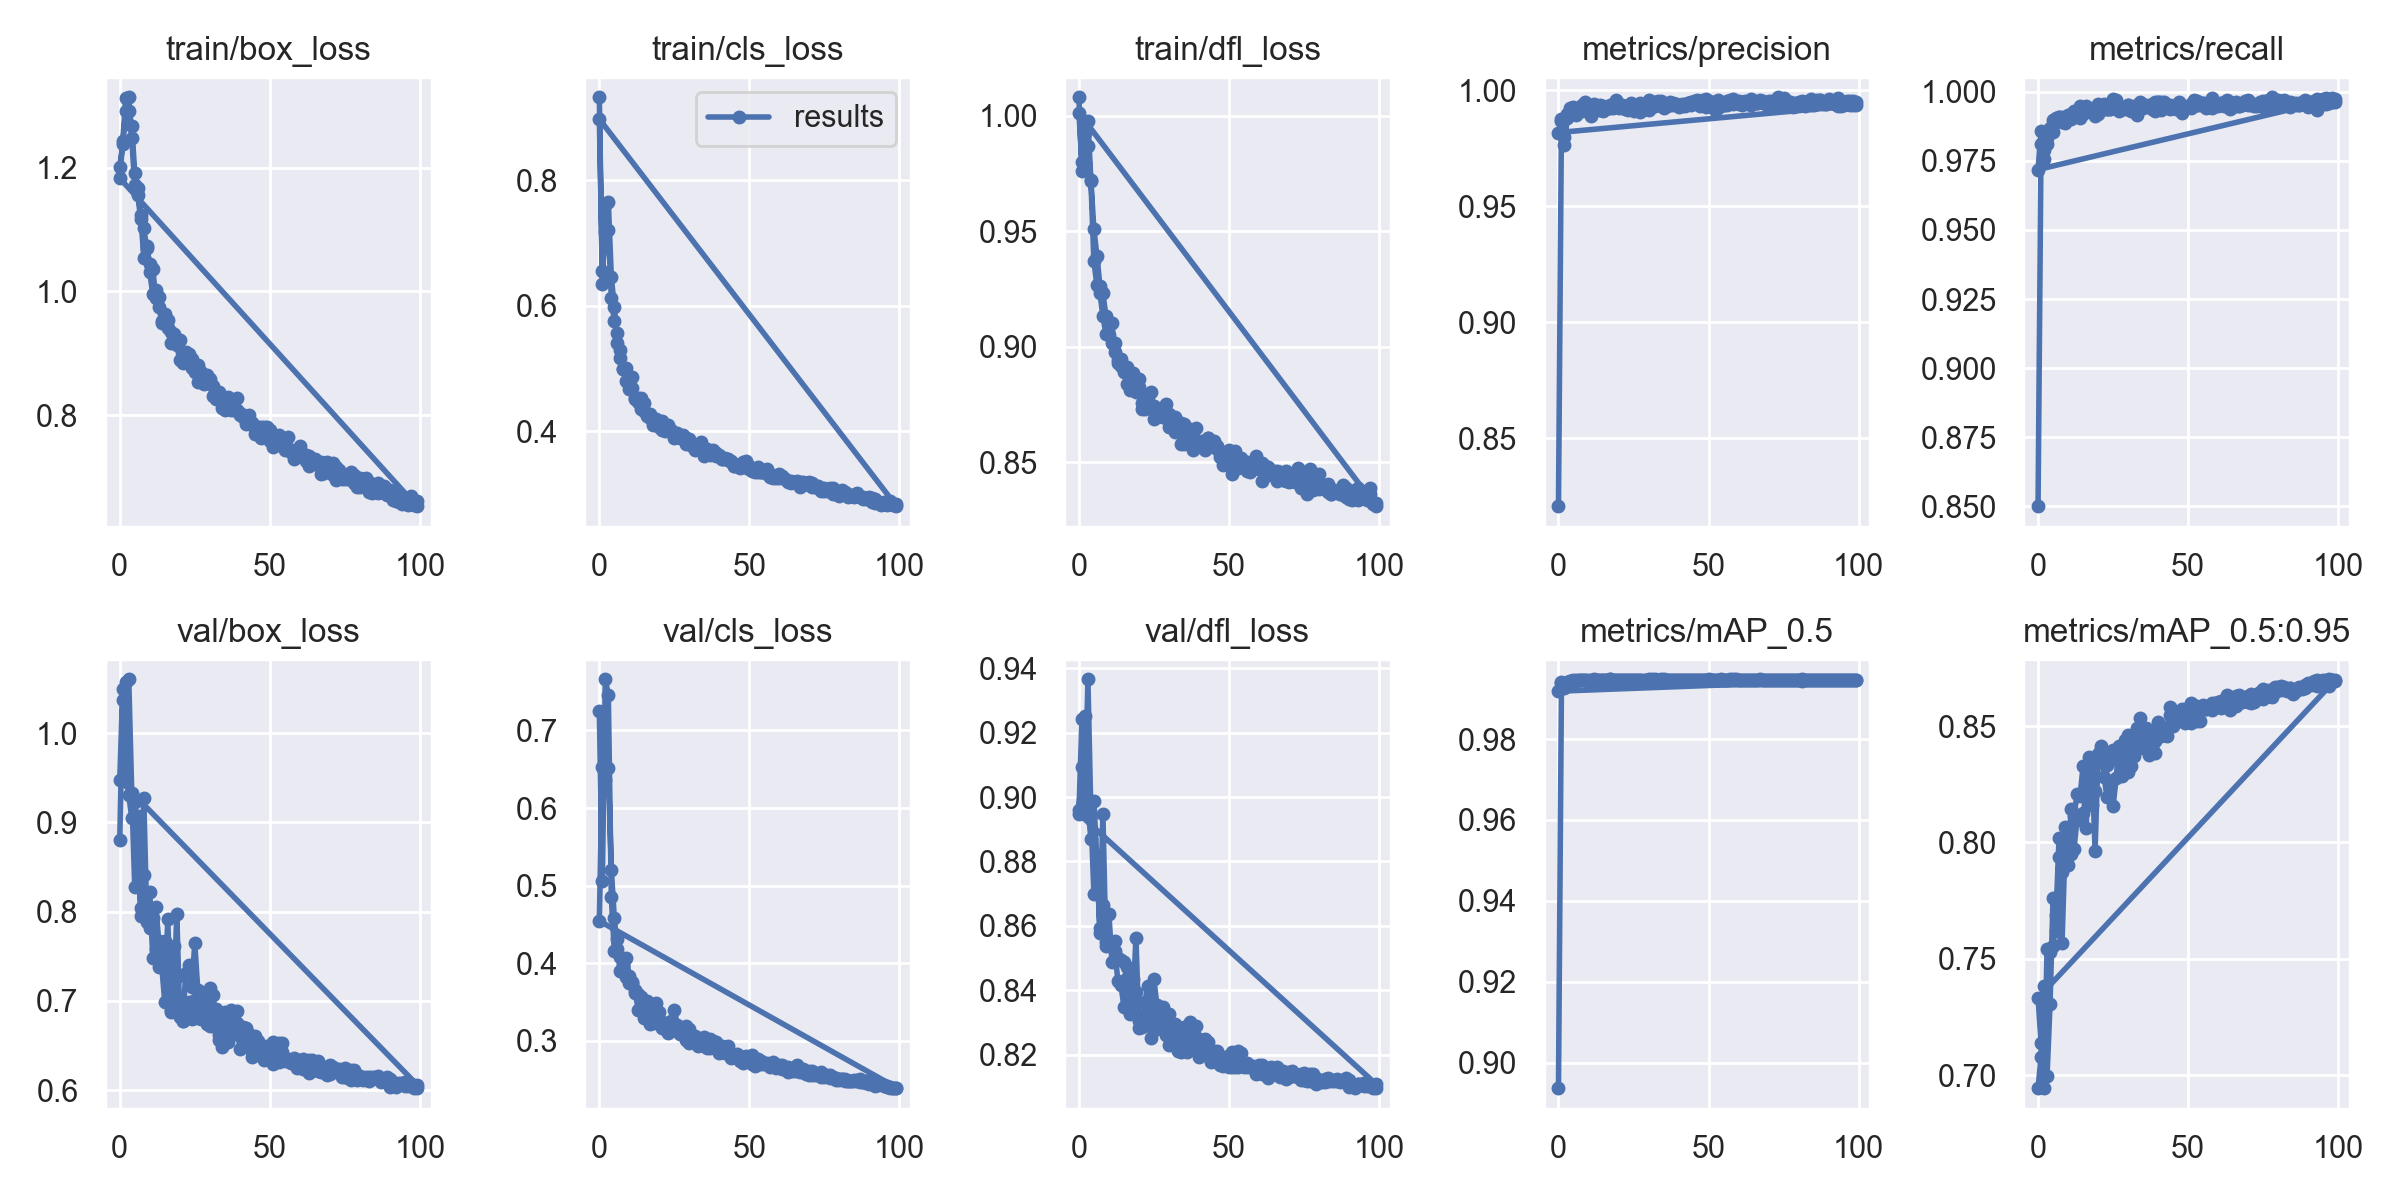


Validation predictions (showing first image):


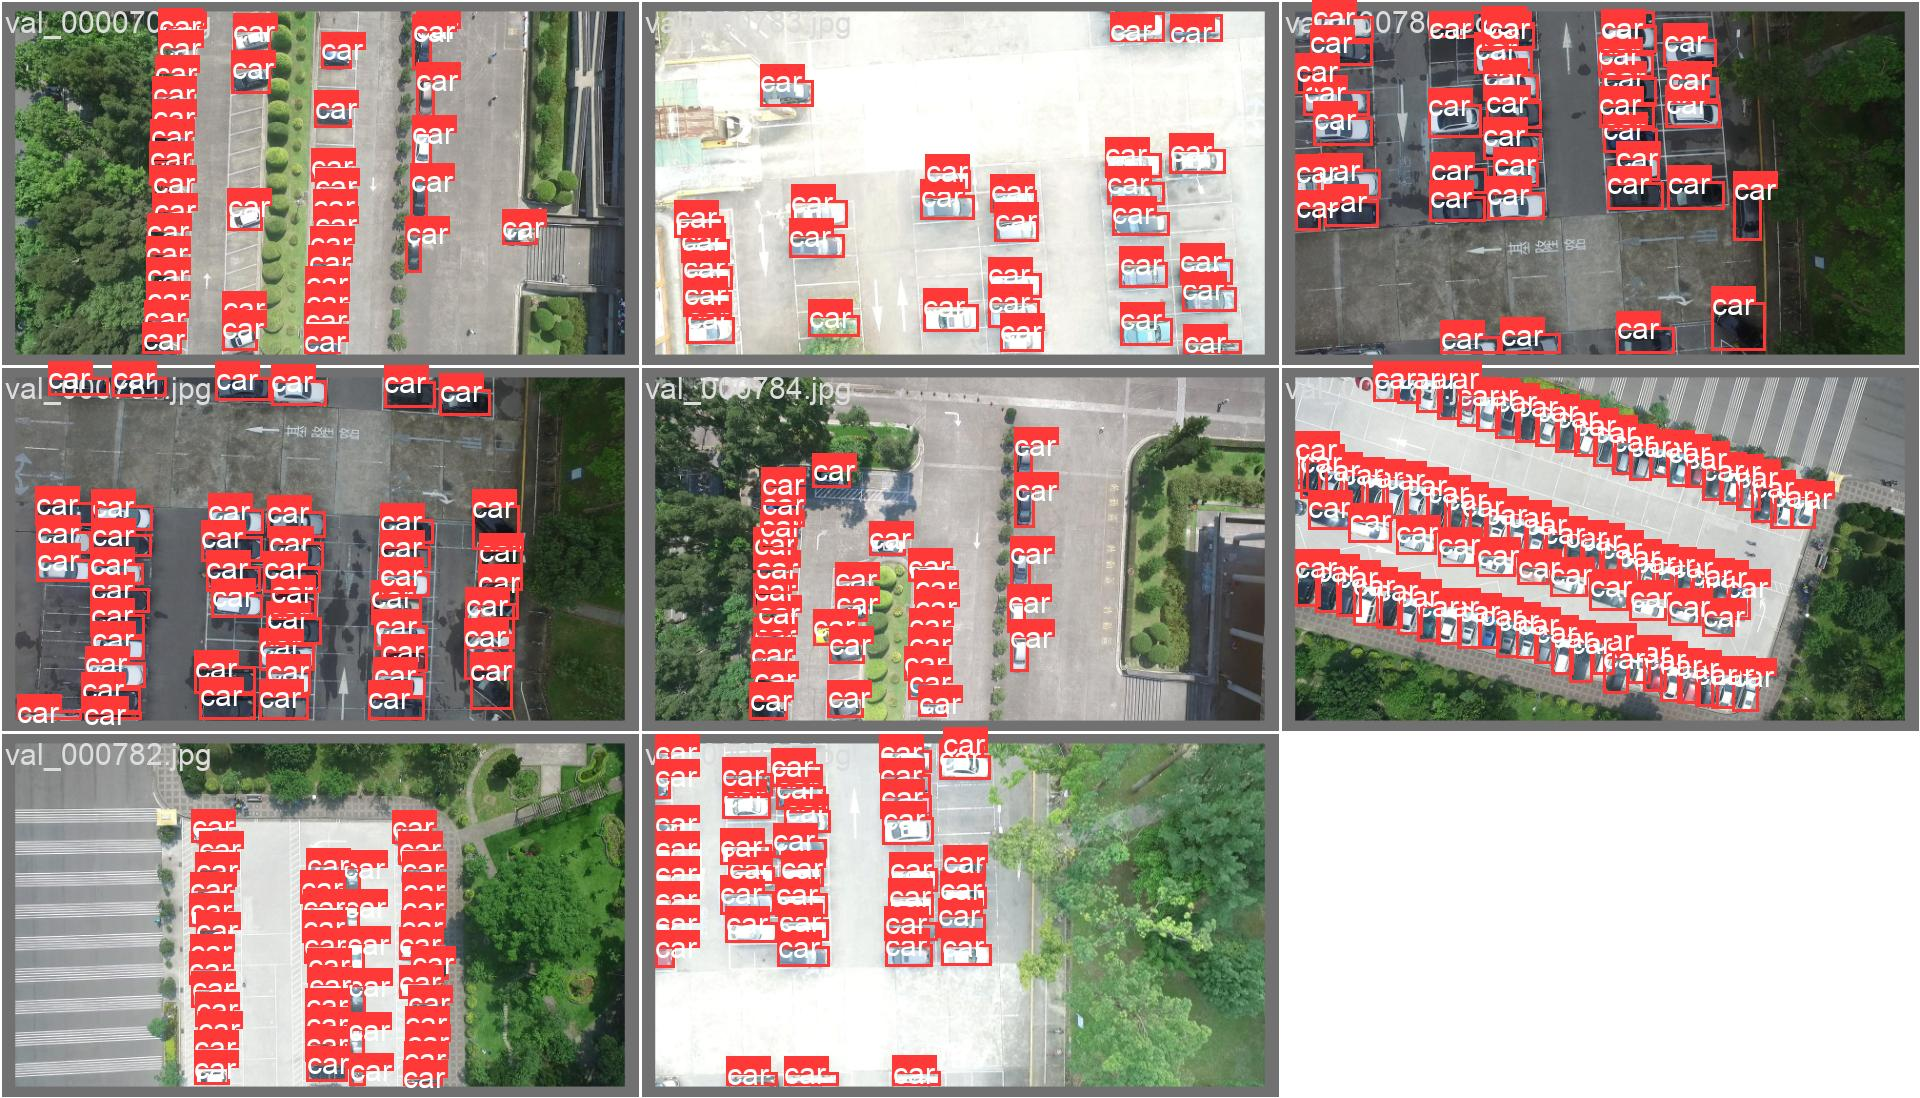

In [33]:
from IPython.display import Image, display
import matplotlib.pyplot as plt

results_dir = Path(config['project']) / config['name']

print("Training Results:")
print(f"Output directory: {results_dir}")
print(f"Best weights: {results_dir / 'weights' / 'best.pt'}")
print(f"Last weights: {results_dir / 'weights' / 'last.pt'}")

results_png = results_dir / 'results.png'
if results_png.exists():
    print("\nTraining curves:")
    display(Image(filename=str(results_png)))
else:
    print("\nresults.png not found")

val_batch_files = list(results_dir.glob('val_batch*.jpg'))
if val_batch_files:
    print(f"\nValidation predictions (showing first image):")
    display(Image(filename=str(val_batch_files[0])))
else:
    print("\nNo validation batch images found")

In [44]:
print("Verifying and forcing patch...")
print("="*70)

general_file = yolov9_dir / 'utils' / 'general.py'

with open(general_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Find the exact line and check what's around it
found_line = None
for i, line in enumerate(lines):
    if 'device = prediction.device' in line:
        found_line = i
        print(f"Found 'device = prediction.device' at line {i+1}")
        print(f"\nContext (lines {max(0,i-3)} to {min(len(lines),i+4)}):")
        for j in range(max(0, i-3), min(len(lines), i+4)):
            print(f"{j+1:4d}: {lines[j]}", end='')
        break

if found_line is not None:
    # Check if patch is before this line
    check_range = lines[max(0, found_line-10):found_line]
    has_patch = any('Handle AuxLoss' in line for line in check_range)
    
    print(f"\n\nPatch already present: {has_patch}")
    
    if not has_patch:
        print("\nApplying patch now...")
        indent = len(lines[found_line]) - len(lines[found_line].lstrip())
        spaces = ' ' * indent
        
        patch_lines = [
            f'{spaces}# Updated: Handle AuxLoss tuple output\n',
            f'{spaces}if isinstance(prediction, (list, tuple)):\n',
            f'{spaces}    if len(prediction) > 0 and isinstance(prediction[0], (list, tuple)):\n',
            f'{spaces}        prediction = prediction[0]\n',
            '\n'
        ]
        
        new_lines = lines[:found_line] + patch_lines + lines[found_line:]
        
        with open(general_file, 'w', encoding='utf-8') as f:
            f.writelines(new_lines)
        
        print("Patch applied successfully!")
    else:
        print("\nPatch exists but not working. Checking patch content...")
        for j in range(max(0, found_line-10), found_line):
            print(f"{j+1:4d}: {lines[j]}", end='')
else:
    print("Could not find 'device = prediction.device' line!")

print("="*70)

Verifying and forcing patch...
Found 'device = prediction.device' at line 910

Context (lines 906 to 913):
 907:         if len(prediction) > 0 and isinstance(prediction[0], (list, tuple)):
 908:             prediction = prediction[0]  # Extract main predictions from AuxLoss output
 909: 
 910:     device = prediction.device
 911:     mps = 'mps' in device.type  # Apple MPS
 912:     if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
 913:         prediction = prediction.cpu()


Patch already present: True

Patch exists but not working. Checking patch content...
 900:     """
 901: 
 902:     if isinstance(prediction, (list, tuple)):  # YOLO model in validation model, output = (inference_out, loss_out)
 903:         prediction = prediction[0]  # select only inference output
 904: 
 905:     # Updated: Handle AuxLoss tuple output
 906:     if isinstance(prediction, (list, tuple)):
 907:         if len(prediction) > 0 and isinstance(prediction[0], (list, tuple)):
 

In [45]:
print("Patching val.py to handle AuxLoss output...")
print("="*70)

val_file = yolov9_dir / 'val.py'

with open(val_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Find where non_max_suppression is called in val.py
patched = False
for i, line in enumerate(lines):
    if 'preds = non_max_suppression(preds' in line and 'Updated for AuxLoss' not in ''.join(lines[max(0,i-5):i]):
        indent = len(line) - len(line.lstrip())
        spaces = ' ' * indent
        
        # Insert patch before the non_max_suppression call
        patch_lines = [
            f'{spaces}# Updated for AuxLoss output\n',
            f'{spaces}if isinstance(preds, (list, tuple)) and len(preds) > 0:\n',
            f'{spaces}    if isinstance(preds[0], (list, tuple)):\n',
            f'{spaces}        preds = preds[0]  # Extract main predictions\n',
            '\n'
        ]
        
        new_lines = lines[:i] + patch_lines + lines[i:]
        
        with open(val_file, 'w', encoding='utf-8') as f:
            f.writelines(new_lines)
        
        print(f"Patched val.py at line {i+1}")
        patched = True
        break

if patched:
    print("Successfully patched val.py")
else:
    print("Could not patch val.py (may already be patched or line not found)")

print("="*70)

Patching val.py to handle AuxLoss output...
Patched val.py at line 201
Successfully patched val.py


Running inference on test set using val.py...
Weights: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\runs\train\carpk_yolov9\weights\best.pt
Data YAML: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml

Running validation on test set...
c:\Users\justi\AppData\Local\Programs\Python\Python311\python.exe val.py --data c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml --weights c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\runs\train\carpk_yolov9\weights\best.pt --batch-size 1 --img-size 640 --task test --save-txt --save-conf --project c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\runs\train\carpk_yolov9 --name test_results --exist-ok


val: data=c:\Users\justi\Documents\parking_analyzer\parking_analyzer\yolo\prepared_data\yolo\data.yaml, weights=['c:\\Users\\justi\\Documents\\parking_analyzer\\parking_analyzer\\yolo\\runs\\train\\carpk_yolov9\\weights

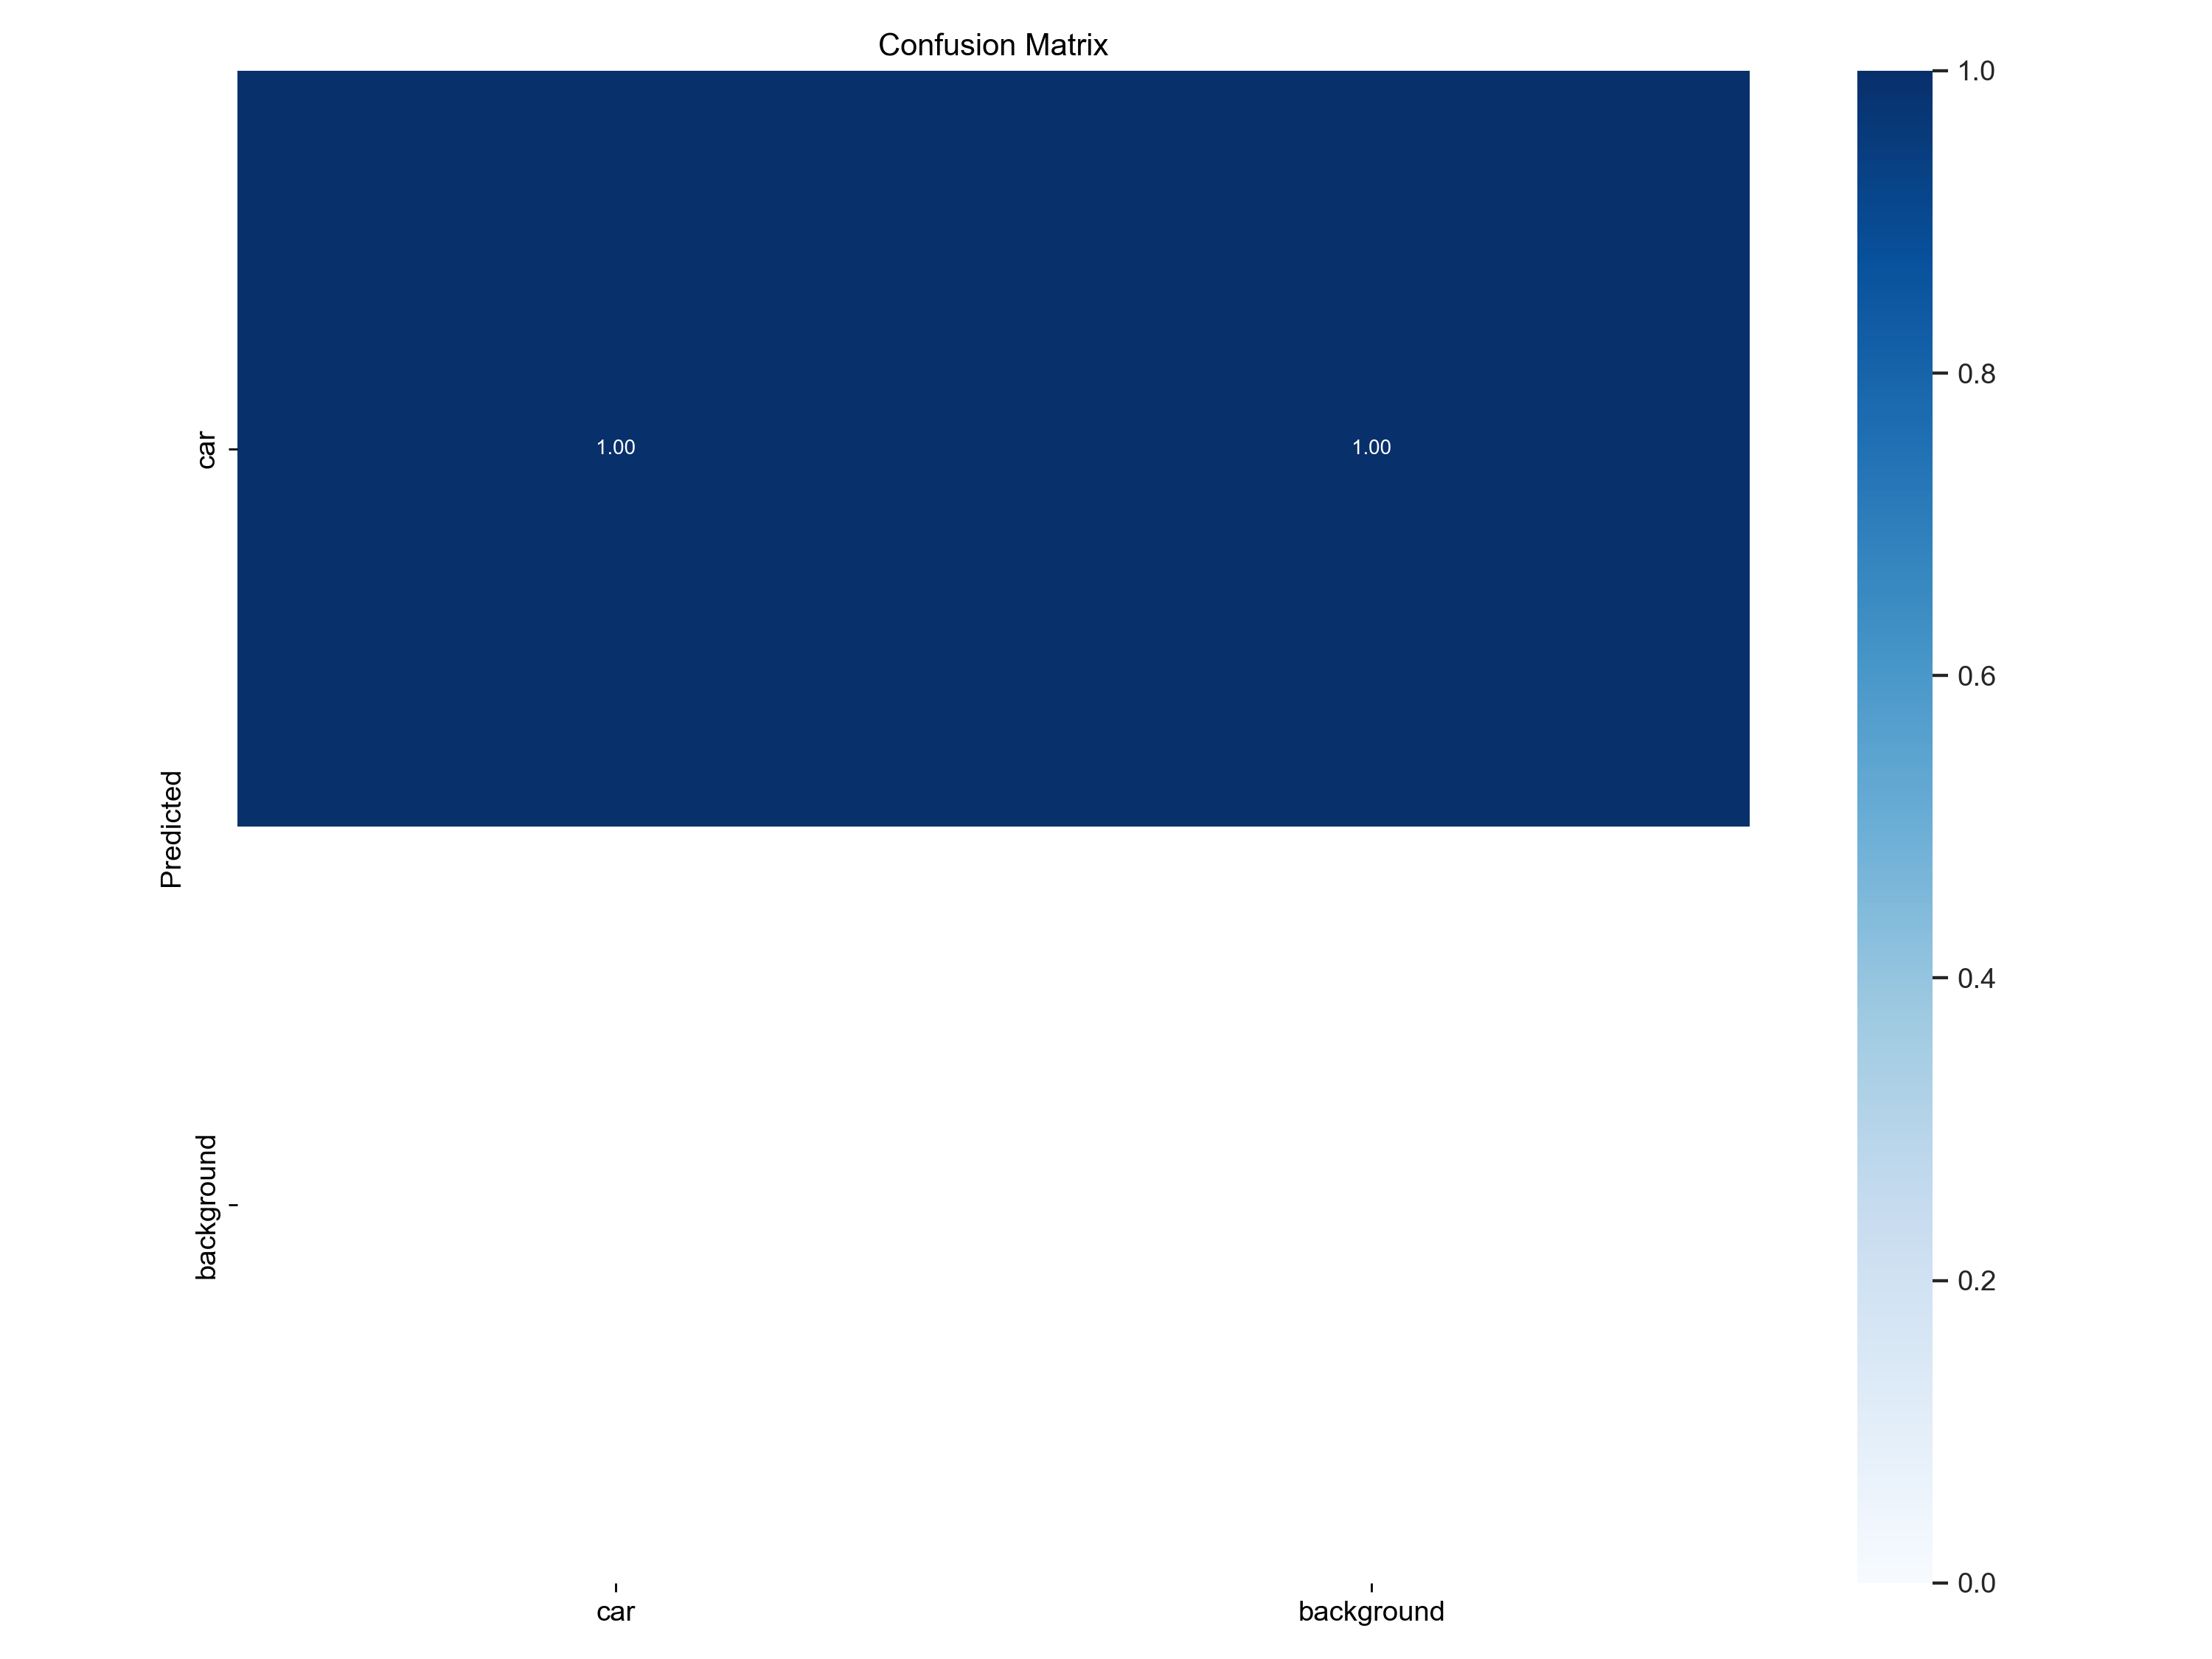


F1_curve.png:


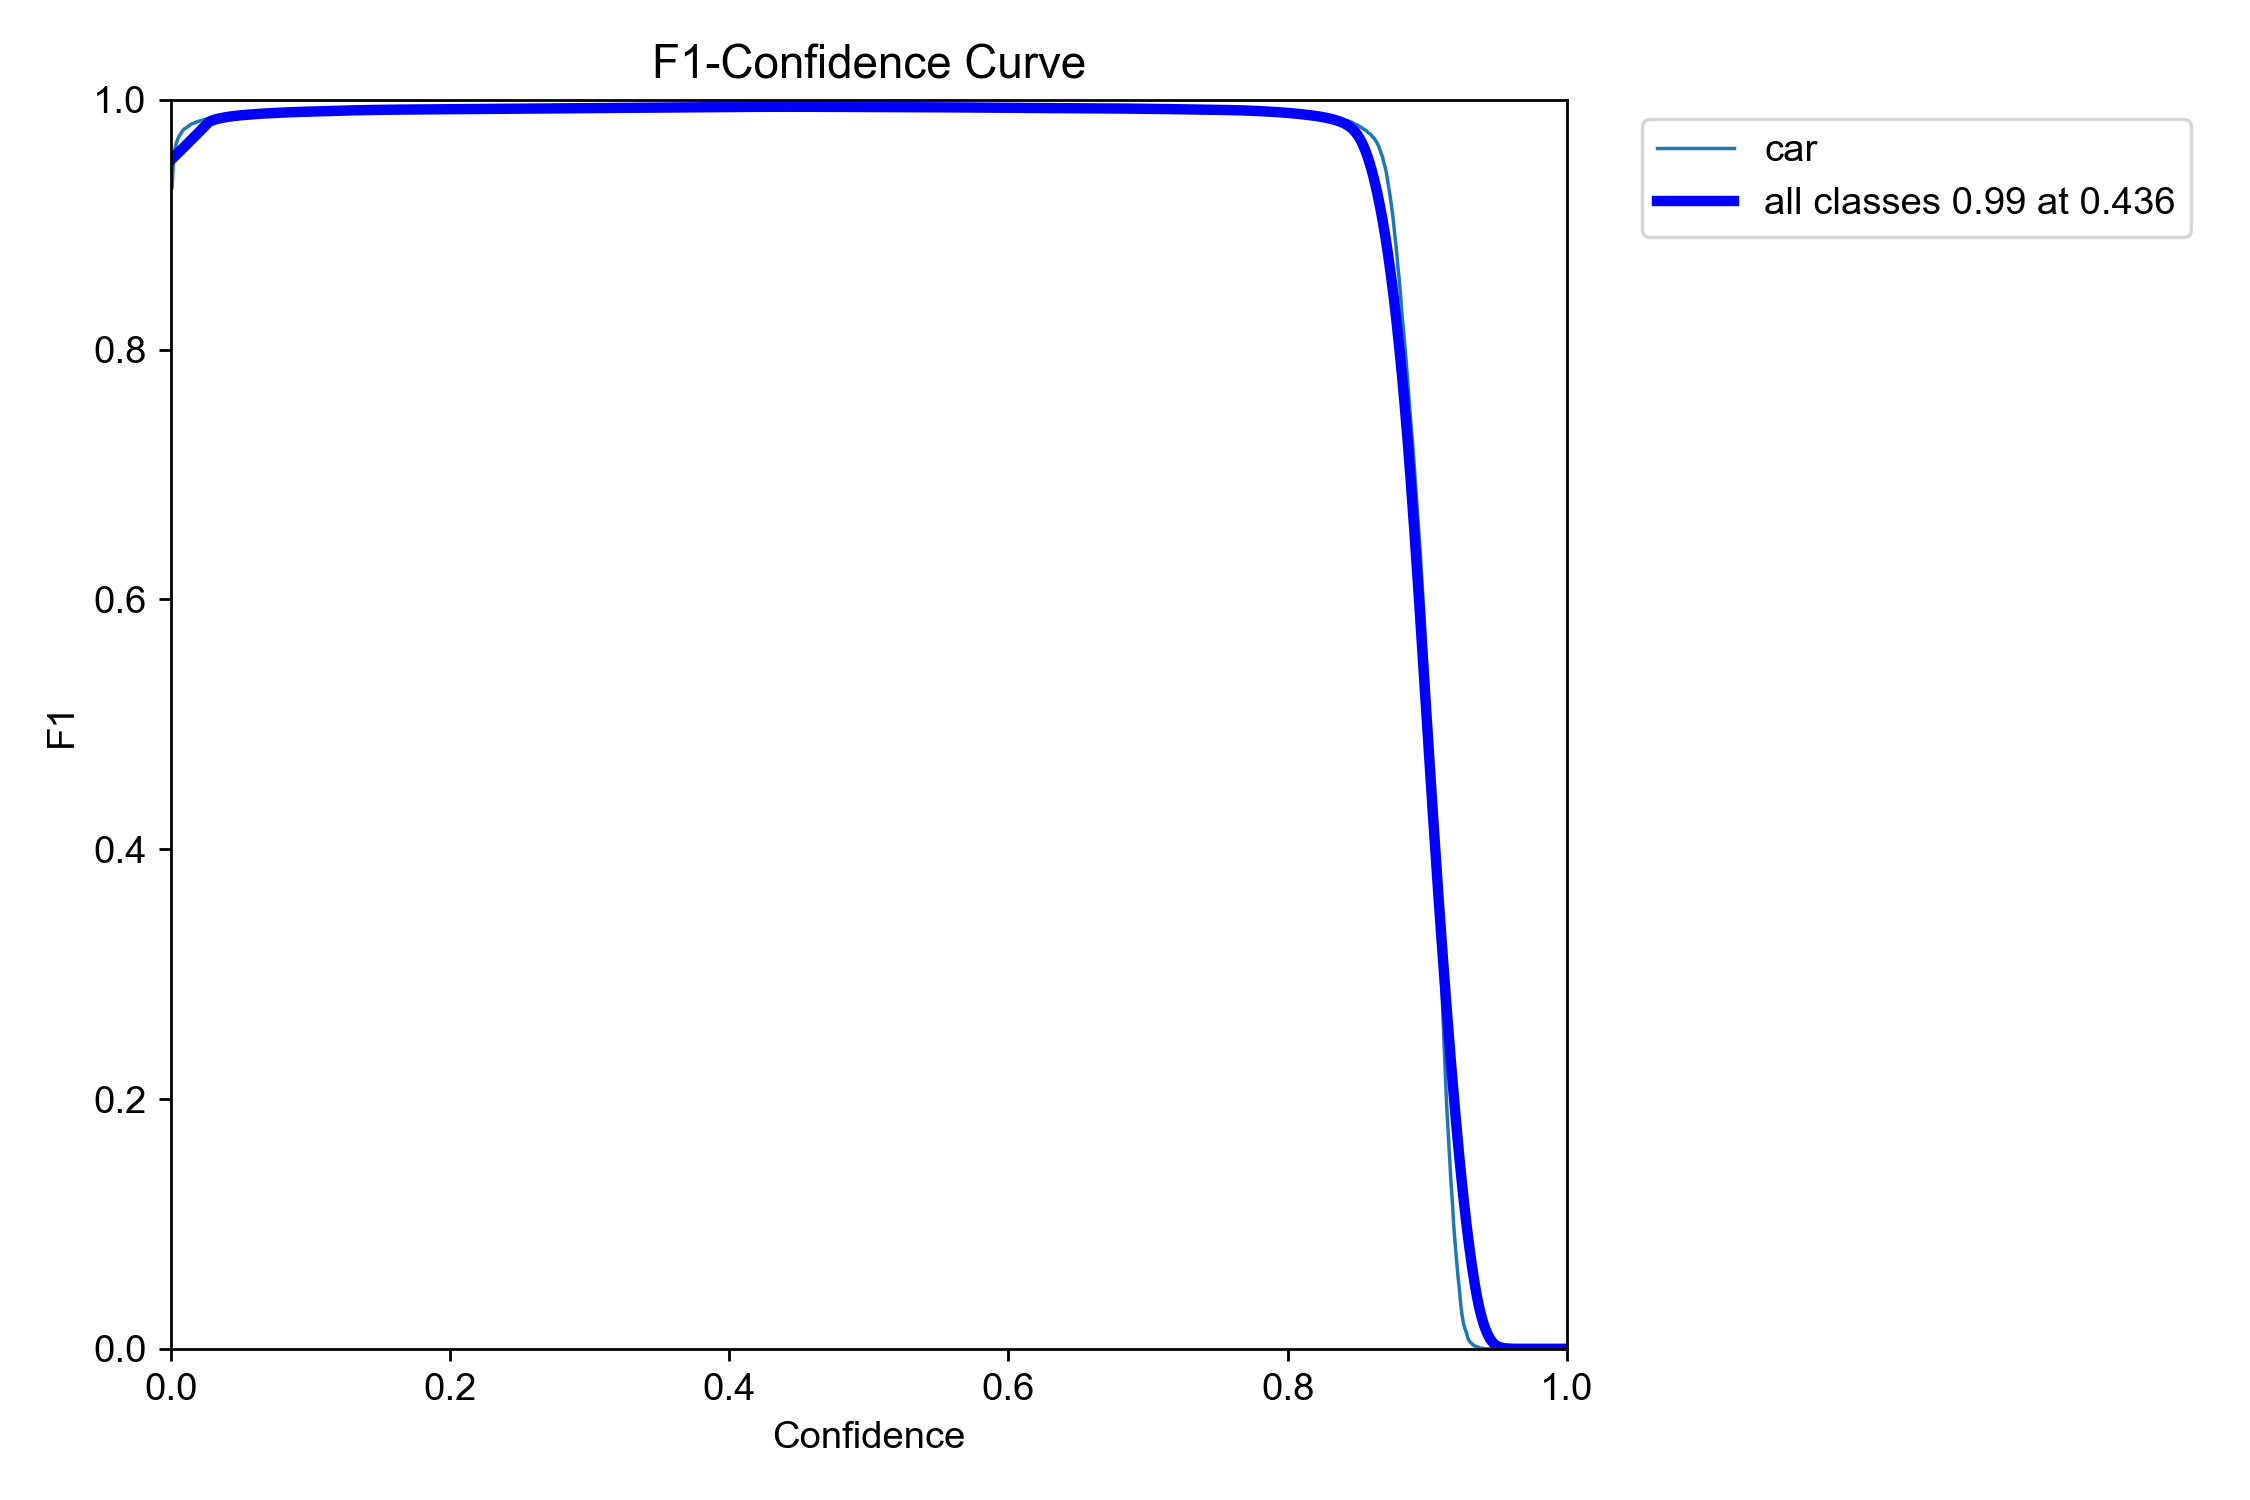


P_curve.png:


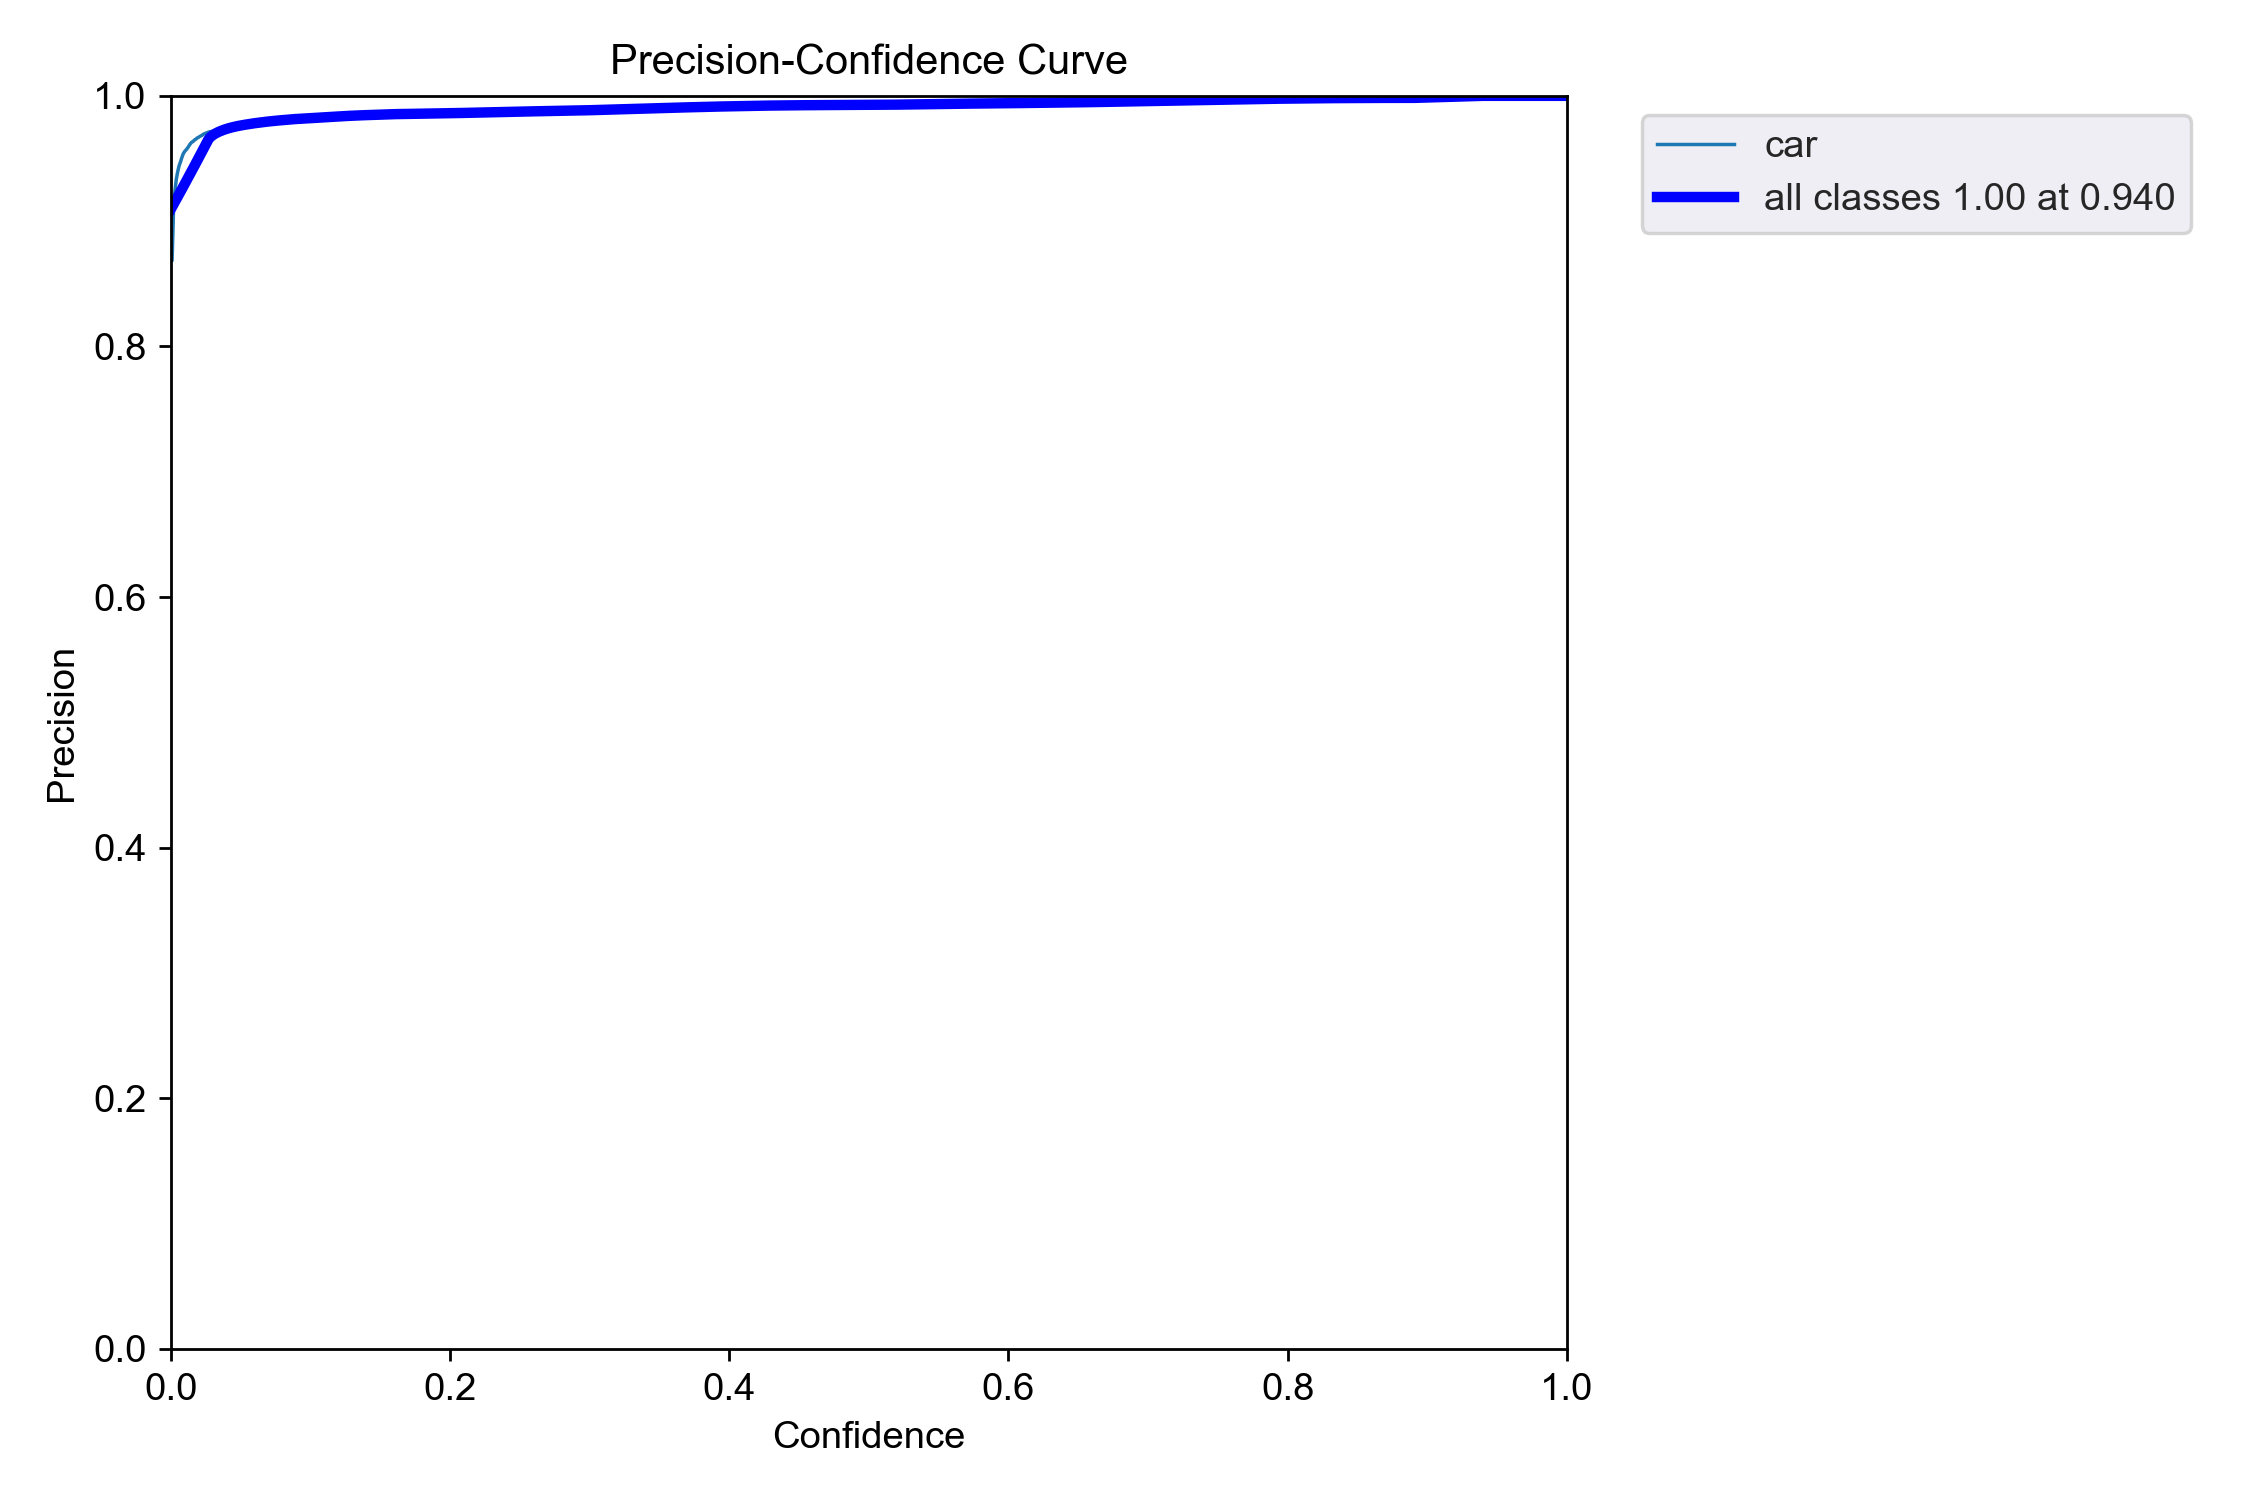

In [46]:
print("Running inference on test set using val.py...")
print("="*70)

original_dir = Path(os.getcwd())

try:
    os.chdir(yolov9_dir)
    
    # Get absolute paths
    best_weights = (original_dir / config['project'] / config['name'] / 'weights' / 'best.pt').absolute()
    data_yaml_path = (original_dir / config['data_yaml']).absolute()
    
    print(f"Weights: {best_weights}")
    print(f"Data YAML: {data_yaml_path}\n")
    
    if not best_weights.exists():
        print("ERROR: Best weights not found!")
    else:
        # Use val.py to run on test set - it's more compatible
        val_cmd = [
            sys.executable,
            'val.py',
            '--data', str(data_yaml_path),
            '--weights', str(best_weights),
            '--batch-size', '1',
            '--img-size', str(config['img_size']),
            '--task', 'test',  # Run on test split
            '--save-txt',
            '--save-conf',
            '--project', str(original_dir / config['project'] / config['name']),
            '--name', 'test_results',
            '--exist-ok'
        ]
        
        print("Running validation on test set...")
        print(' '.join(val_cmd))
        print("\n" + "="*70 + "\n")
        
        process = subprocess.Popen(
            val_cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            errors='replace'
        )
        
        for line in process.stdout:
            print(line, end='')
        
        process.wait()
        
        print("\n" + "="*70)
        if process.returncode == 0:
            print("Test evaluation completed successfully!")
        else:
            print(f"Test evaluation failed with exit code: {process.returncode}")
        print("="*70)
            
finally:
    os.chdir(original_dir)

# Display results
results_dir = original_dir / config['project'] / config['name'] / 'test_results'
if results_dir.exists():
    print(f"\nTest results saved to: {results_dir}")
    
    # Look for prediction images
    pred_images = sorted(list(results_dir.glob('*.jpg')) + list(results_dir.glob('*.png')))
    if pred_images:
        print(f"\nShowing first 3 test results:")
        for img_file in pred_images[:3]:
            print(f"\n{img_file.name}:")
            display(Image(filename=str(img_file)))

## Summary

Training is complete. The best model weights are saved and ready for evaluation or deployment.

### Next Steps
1. Review training curves in results.png
2. Check validation predictions
3. Run evaluation script for detailed metrics
4. Use best.pt for inference on new images